
# Goal Portfolio — Monte Carlo Demo Notebook

This notebook demonstrates:
- Probability of goal completion (Monte Carlo)
- Projection band (P10 / P50 / P90) to horizon
- Simulated wealth paths
- End-wealth distribution

**How to use:** edit the **CONFIG** in the first code cell and re-run all.


In [116]:

# === CONFIG (edit me) =========================================================
from dataclasses import dataclass

@dataclass
class Config:
    # Goal
    W0: float = 150_000_000.0                 # Starting NAV (IDR)
    target_FV: float = 1_000_000_000.0        # Target at horizon (IDR, nominal)
    horizon_months: int = 48                  # Months to goal
    contribution: float = 15_000_000.0        # Monthly contribution (IDR), start-of-month
    # Market (annual arithmetic assumptions)
    annual_return: float = 0.118              # Expected annual return
    annual_vol: float = 0.195                 # Annual volatility
    # Simulation
    paths: int = 2000
    seed: int | None = 1234
    store_paths: bool = True

CONFIG = Config()
print(CONFIG)


Config(W0=150000000.0, target_FV=1000000000.0, horizon_months=48, contribution=15000000.0, annual_return=0.118, annual_vol=0.195, paths=2000, seed=1234, store_paths=True)


In [117]:

# === Imports and engine loader ===============================================
import os, importlib.util, sys
import pandas as pd

ENGINE_PATH = "./goal_engine.py"

def load_goal_engine(path: str):
  spec = importlib.util.spec_from_file_location("goal_engine", path)
  mod = importlib.util.module_from_spec(spec)
  sys.modules["goal_engine"] = mod
  spec.loader.exec_module(mod)
  return mod

ge = load_goal_engine(ENGINE_PATH)
print("Loaded goal_engine from:", ENGINE_PATH)


Loaded goal_engine from: ./goal_engine.py


In [118]:
from datetime import datetime, timedelta


# === Run simulation ===========================================================
goal = ge.GoalParams(
    W0=CONFIG.W0,
    target_FV=CONFIG.target_FV,
    horizon_months=CONFIG.horizon_months,
    contributions=CONFIG.contribution
)
market = ge.MarketParams(annual_return=CONFIG.annual_return, annual_vol=CONFIG.annual_vol)
cfg = ge.SimulationConfig(paths=CONFIG.paths, seed=CONFIG.seed, store_paths=CONFIG.store_paths)

res = ge.simulate_goal_mc(goal, market, cfg)

def idr(x: float) -> str:
    return f"Rp {x:,.0f}".replace(",", ".")

# Calculate the horizon date
horizon_date = (datetime.now() + timedelta(days=CONFIG.horizon_months * 30)).strftime("%d %B %Y")

summary = pd.DataFrame({
  "Metric": [
    "As-of", "Until", "Paths", "Horizon (mo)", "W0", "Sum(contrib)", "Target",
    "E[G]_month", "m_month", "s_month",
    "P10 end", "P50 end", "P90 end", "Prob Completion (MC)"
  ],
  "Value": [
    pd.to_datetime(res["as_of"]).strftime("%d %B %Y"), horizon_date, res["as_of_params"]["paths"], res["as_of_params"]["horizon_months"],
    idr(res["as_of_params"]["W0"]), idr(res["as_of_params"]["contributions_sum"]),
    idr(res["as_of_params"]["target_FV"]), f"{(res['as_of_params']['E_G_month']-1)*100:.3f}%",
    f"{res['as_of_params']['m_month']:.5f}", f"{res['as_of_params']['s_month']:.5f}",
    idr(res["percentiles"]["p10"]), idr(res["percentiles"]["p50"]), idr(res["percentiles"]["p90"]),
    f"{res['prob_completion']*100:.1f}%"
  ]
})
summary


,Metric,Value
0,As-of,23 October 2025
1,Until,02 October 2029
2,Paths,2000
3,Horizon (mo),48
4,W0,Rp 150.000.000
5,Sum(contrib),Rp 720.000.000
6,Target,Rp 1.000.000.000
7,E[G]_month,0.934%
8,m_month,0.00771
9,s_month,0.05629


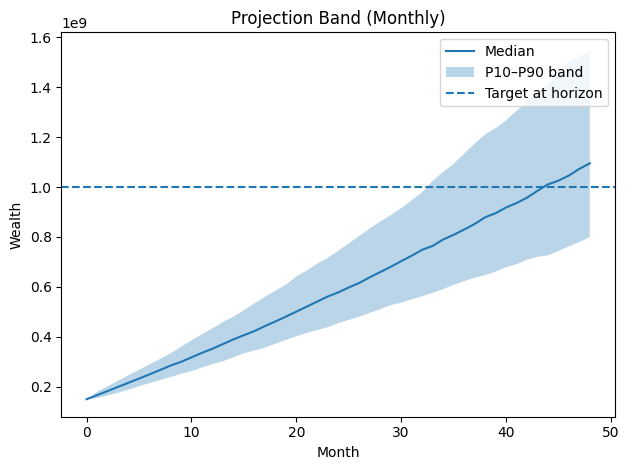

In [119]:

# === Plot 1: Projection band (P10–P90 with median) ===========================
ge.plot_projection_band(res["time_grid"], res["projection_band"], goal.target_FV)


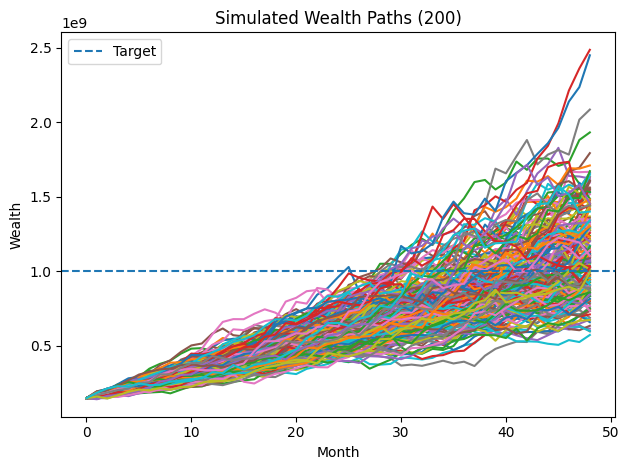

In [120]:

# === Plot 2: Simulated wealth paths ==========================================
ge.plot_simulated_paths(res["time_grid"], res["paths_sample"], goal.target_FV)


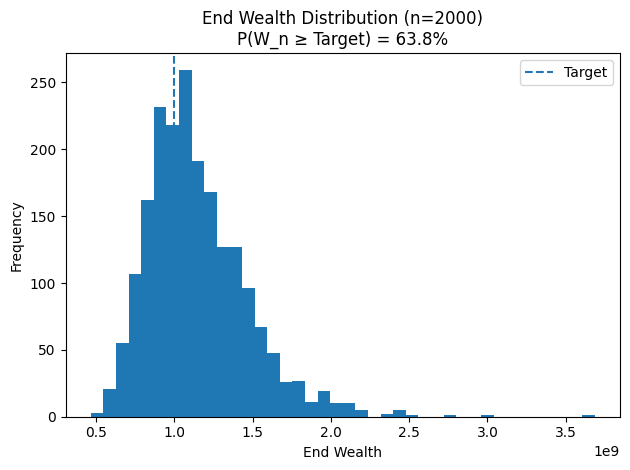

In [121]:

# === Plot 3: End-wealth distribution =========================================
ge.plot_end_wealth_distribution(res["end_values"], goal.target_FV, res["prob_completion"])
